In [1]:
import json
import logging
import math
import os
import time
from collections import defaultdict
from datetime import datetime
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.multiprocessing as mp
from sklearn.metrics._ranking import _binary_clf_curve
from tabulate import tabulate
from torch.multiprocessing import Process, set_start_method
from tqdm import tqdm

DISEASE = "aneurysm"


class FROCEvaluator:
    def __init__(
        self,
        label_file,
        # pred_file,
        preds,
        *,
        logger=None,
        iou_thr=0.4,
        out_dir=None,
        max_fppi=None,
        n_workers=8,
        n_bootstraps=10000,
        ci=0.95,
        n_fppi=10000,
        fppi_thrs=[
            0.125,
            0.25,
            0.5,
            1.0,
        ],
        seed=0,
        out_bs=500,
        save_curves=False,
        min_fppi=1e-4,
        fp_scale="linear",
        meta_data=None,
    ):
        assert fp_scale in ["linear", "log"]
        self._iou_thr = iou_thr
        self._out_dir = out_dir
        if out_dir is not None:
            os.makedirs(out_dir + "/figures", exist_ok=True)
            os.makedirs(out_dir + "/bt_cache", exist_ok=True)
            os.makedirs(out_dir + "/curves", exist_ok=True)
        self._max_fppi = max_fppi
        self._min_fppi = min_fppi

        self._fp_scale = fp_scale
        self._n_fppi = n_fppi
        self._fppi_thrs = np.array(fppi_thrs)
        self._metric_names = [f"Se@FPpI={x:.1f}" for x in fppi_thrs]
        self._n_workers = n_workers
        self._n_bootstraps = n_bootstraps
        self._ci = ci
        self._seed = seed
        self._out_bs = out_bs
        self._save_curves = save_curves
        self._logger = logging.getLogger(__name__) if logger is None else logger

        # self._gts, self._categories, self._images = self.parse_gt_json(label_file)
        self._gts, self._categories, self._images = self.parse_gt_csv(label_file)
        # self._dts = self.parse_dt_json(preds, self._categories)
        self._dts = self.parse_dt_csv(preds, self._categories, meta=meta_data)

        # compute totol pos per category
        n_pos_per_cat = {}
        for cat in self._categories.values():
            n_pos = sum([len(x["box"]) for x in self._gts[cat].values()])
            n_pos_per_cat[cat] = n_pos
        print(n_pos_per_cat)
        self._n_pos_per_cat = n_pos_per_cat
        self._images = [f"Ts{i:0>4}.nii.gz" for i in range(1, 153)]

    def evaluate(self):
        # compute iou

        ious = {}  # category -> img_id -> iou matrix
        for category in self._categories.values():
            per_cat_ious = {}
            for img_id in self._images:
                pred = self._dts[category].get(img_id, {"box": []})["box"]
                gt = self._gts[category].get(img_id, {"box": []})["box"]
                iou = None
                if len(pred) and len(gt):
                    iou = self._pairwise_iou(gt, pred)
                per_cat_ious[img_id] = iou
            ious[category] = per_cat_ious

        # matching per category per image detection
        # image_id -> category -> {
        #    'scores': list of score,
        #    'gts': list of corresponding gt
        # }
        match_result = defaultdict(dict)
        for img_id in self._images:
            for category in self._categories.values():
                p_boxes = self._dts[category].get(img_id, {"box": []})["box"]
                p_scores = self._dts[category].get(img_id, {"score": []})["score"]
                gts = self._gts[category].get(img_id, [])
                if isinstance(gts, dict):
                    gts = gts["box"]

                match_result[img_id][category] = self._match(
                    p_boxes, p_scores, gts, ious[category][img_id], self._iou_thr
                )
        self._match_results = match_result

        # self._compute_froc(save_fig=True)

    def get_bootstrap_data(self):
        match_results = self._match_results
        match_list, n_pos = [], []
        categories = list(self._categories.values())
        gts = self._gts
        for img_id in self._images:
            match_list.append(match_results[img_id])
            pos = {c: len(gts[c].get(img_id, {"box": []})["box"]) for c in categories}
            n_pos.append(pos)

        return match_list, n_pos, categories

    def _compute_froc(self, save_fig=False):
        fppi_thrs = self._fppi_thrs
        cats = []
        results = []
        n_imgs = len(self._images)
        print("computing froc ...")
        for category in tqdm(self._categories.values()):
            cats.append(category)
            gts, preds = [], []
            for match in self._match_results.values():
                gts.append(match[category]["gts"])
                preds.append(match[category]["scores"])
            gts = np.concatenate(gts)
            preds = np.concatenate(preds)

            recalls, FPpI, _ = compute_froc(
                preds, gts, self._n_pos_per_cat[category], n_imgs
            )
            results.append(np.interp(fppi_thrs, FPpI, recalls))
            print(np.interp(fppi_thrs, FPpI, _))
            if save_fig:
                self._save_fig(recalls, FPpI, category)

            if self._save_curves:
                cat_file_name = category.replace("/", "_").replace(" ", "_").lower()
                torch.save(
                    {"recall": recalls, "fppi": FPpI},
                    os.path.join(self._out_dir, "curves", f"curve_{cat_file_name}.pth"),
                )
        self._derive_results(cats, results)

    def _derive_results(self, classes, results):
        def f2str(x):
            if x < 0.9995:
                return f"{x:.3f}"[1:]
            return "1.00"

        def str2f(x):
            if x[0] == "1":
                return 1.0
            return float(f"0{x}")

        metric_names = self._metric_names
        results_table = []
        for cat, k_results in zip(classes, results):
            row = [cat] + [f2str(float(x)) for x in k_results]
            results_table.append(row)

        headers = ["Finding"] + metric_names
        df = pd.DataFrame(results_table, columns=headers)
        means = {}
        for metric in metric_names:
            means[metric] = f2str(df[metric].apply(lambda x: str2f(x[:4])).mean())
        means[headers[0]] = "Mean"
        df.loc["mean"] = means
        df.to_csv(os.path.join(self._out_dir, "froc.csv"), index=False, columns=headers)

        table = tabulate(
            results_table + [[means[x] for x in headers]],
            tablefmt="pipe",
            floatfmt=".3f",
            headers=headers,
            numalign="left",
        )
        self._logger.info("Per-finding bbox FROC \n" + table)

    def _compute_bootstrap(self):
        start = time.perf_counter()
        n_workers = self._n_workers
        n_bootstraps = self._n_bootstraps
        global_count = mp.Value("i", 0)
        # results_queue = mp.Queue()
        barrier = mp.Barrier(n_workers + 1)
        match_list, n_pos, categories = self.get_bootstrap_data()

        workers = [
            BootstrapWorker(
                pid=i,
                global_count=global_count,
                barrier=barrier,
                # results_queue=results_queue,
                n_bootstraps=n_bootstraps,
                seed=self._seed + i,
                match_list=match_list,
                n_pos=n_pos,
                categories=categories,
                out_dir=self._out_dir,
                out_bs=self._out_bs
                # max_fppi=self._max_fppi,
                # min_fppi=self._min_fppi,
                # n_fppi=self._n_fppi
            )
            for i in range(n_workers)
        ]
        for worker in workers:
            worker.start()
        print("init time ", time.perf_counter() - start)
        barrier.wait()

        num_bootstraps = global_count.value
        print(f"got total of {num_bootstraps} bootstraps")
        # results = []
        # for i in range(num_bootstraps):
        #     results.append(results_queue.get())

        for worker in workers:
            worker.join()
        print("main run time", time.perf_counter() - start)

    def _process_bootstrap(self):
        n_bootstraps = self._n_bootstraps
        fppi_thrs = self._fppi_thrs
        scale = self._fp_scale
        max_fppi = self._max_fppi
        assert max_fppi is not None

        m_res, lb_res, ub_res = [], [], []
        cats = []
        mean_frocs = np.zeros((len(self._categories), n_bootstraps, len(fppi_thrs)))
        print("processing bootstrap results ...")
        for cat_id, cat in enumerate(tqdm(self._categories.values())):
            # print("processing ", cat)

            cats.append(cat)
            max_fppi_c = (
                float(max_fppi) if isinstance(max_fppi, (int, float)) else max_fppi[cat]
            )
            if scale == "linear":
                fppi_grid = np.linspace(self._min_fppi, max_fppi_c, num=self._n_fppi)
            else:
                fppi_grid = np.exp(
                    np.linspace(
                        np.log(self._min_fppi),
                        np.log(max_fppi_c),
                        num=self._n_fppi,
                    )
                )
            cat_file_name = cat.replace("/", "_").replace(" ", "_").lower()
            files = glob(
                os.path.join(self._out_dir, "bt_cache", f"worker*{cat_file_name}.pth")
            )
            files = sorted(files)

            bt_id = 0
            interpolated_recall = np.zeros((n_bootstraps, len(fppi_grid)))
            specific_recall = np.zeros((n_bootstraps, len(fppi_thrs)))
            for _file in files:
                results = torch.load(_file)
                for recall, fppi in zip(results["recalls"], results["fppi"]):
                    if bt_id == n_bootstraps:
                        break
                    interpolated_recall[bt_id] = np.interp(fppi_grid, fppi, recall)
                    specific_recall[bt_id] = np.interp(fppi_thrs, fppi, recall)

                    bt_id += 1

            mean_frocs[cat_id] = specific_recall

            # get bootstrap curve
            recall_m, recall_lb, recall_ub = get_mean_ci(interpolated_recall, self._ci)
            self._save_fig(recall_m, fppi_grid, cat, rec_ub=recall_ub, rec_lb=recall_lb)
            if self._save_curves:
                torch.save(
                    {
                        "m_recall": recall_m,
                        "lb_recall": recall_lb,
                        "ub_recall": recall_ub,
                        "fppi": fppi_grid,
                    },
                    os.path.join(
                        self._out_dir, "curves", f"bt_curve_{cat_file_name}.pth"
                    ),
                )
            # recall at specific threshold
            rec_m, rec_lb, rec_ub = get_mean_ci(specific_recall, self._ci)
            m_res.append(rec_m)
            lb_res.append(rec_lb)
            ub_res.append(rec_ub)
            # print("Done bt froc", cat)

        mean_frocs = mean_frocs.mean(axis=0)
        rec_m, rec_lb, rec_ub = get_mean_ci(mean_frocs, self._ci)
        m_res.append(rec_m)
        lb_res.append(rec_lb)
        ub_res.append(rec_ub)
        cats.append("Mean")

        self._derive_bt_results(cats, m_res, ub_res, lb_res)

    def _derive_bt_results(self, classes, m_results, ub_results, lb_results):
        """
        results: shape (K,M) K: num classes, M: num metrics
        """

        def f2str(x):
            if x < 0.9995:
                return f"{x:.3f}"[1:]
            return "1.00"

        def str2f(x):
            if x[0] == "1":
                return 1.0
            return float(f"0{x}")

        metric_names = self._metric_names
        results_table = []
        for cat, k_means, k_lbs, k_ubs in zip(
            classes, m_results, lb_results, ub_results
        ):
            row = [cat]
            for mean, lb, ub in zip(k_means, k_lbs, k_ubs):
                # print(mean, lb, ub)
                row.append(
                    f"{f2str(float(mean))}({f2str(float(lb))}--{f2str(float(ub))})"
                )
            results_table.append(row)

        headers = ["Finding"] + metric_names
        df = pd.DataFrame(results_table, columns=headers)
        # means = {}
        # for metric in metric_names:
        #     means[metric] = f2str(df[metric].apply(lambda x: str2f(x[:4])).mean())
        # means[headers[0]] = "Mean"
        # df.loc['mean'] = means
        df.to_csv(
            os.path.join(self._out_dir, "froc_bt.csv"), index=False, columns=headers
        )

        table = tabulate(
            # results_table + [[means[x] for x in headers]],
            results_table,
            tablefmt="pipe",
            floatfmt=".3f",
            headers=headers,
            numalign="left",
        )
        self._logger.info("Per-finding bbox FROC \n" + table)

    def _save_fig(self, recalls, FPpI, category, *, rec_ub=None, rec_lb=None):
        assert self._out_dir is not None
        plt.close()
        path = os.path.join(
            self._out_dir, "figures", f"{category.replace('/', '_')}_froc.png"
        )
        plt.figure(figsize=(5, 5))
        plt.title(f"{category} FROC")
        plt.plot(FPpI, recalls)
        plt.xlabel("Average number of false positive per scan")
        plt.ylabel("Recall")
        if self._fp_scale == "log":
            plt.xscale("log")
        if rec_lb is not None:
            path = path.replace("froc.", "froc_bootstrap.")
            plt.plot(
                FPpI,
                rec_ub,
                "r--",
                FPpI,
                rec_lb,
                "r--",
            )
        xmax = FPpI.max()
        max_fppi = self._max_fppi
        if max_fppi:
            if isinstance(max_fppi, (float, int)):
                xmax = float(max_fppi)
            else:
                xmax = float(max_fppi[category])
        if self._fp_scale == "log":
            xmin = self._min_fppi
        else:
            xmin = -0.1
        plt.xlim(xmin, xmax)
        plt.ylim(xmin, 1.01)
        plt.grid(linestyle="--", which="both")
        plt.savefig(path)

    def _match(self, p_boxes, p_scores, gts, ious, iou_thr):
        """
        assess whether each pred is pos or neg
        args
            threshold: iou threshold to match

        return
        """
        assert len(p_boxes) == len(p_scores)
        # no_pred_score = -0.01
        if not (len(gts) or len(p_scores)):
            return {"scores": np.array([]), "gts": np.array([])}

        if not len(gts):
            scores = p_scores.numpy()
            gts = np.zeros_like(scores)
            return {"scores": scores, "gts": gts}

        if not len(p_scores):
            # gts = np.ones(size=(len(gts),))
            # scores = no_pred_score * gts
            # return {"scores": scores, "gts": gts}
            return {"scores": np.array([]), "gts": np.array([])}

        un_matched_gt = torch.ones(size=(ious.size(0) + 1,))
        _, sorted_ids = torch.sort(p_scores, descending=True)
        r_scores, r_gts = [], []
        r_bboxes, gt_boxes = [], []
        for i in sorted_ids:
            i_iou = ious[:, i]
            matched_gt_id = -1
            best_iou = -1
            for gt_id, iou in enumerate(i_iou):
                if iou >= iou_thr and un_matched_gt[gt_id] > 0 and iou > best_iou:
                    matched_gt_id = gt_id
                    best_iou = iou

            # update un_matched_gt
            un_matched_gt[matched_gt_id] = 0

            # update results
            gt = 1.0 if matched_gt_id > -1 else 0.0
            r_gts.append(gt)
            r_scores.append(float(p_scores[i]))
            r_bboxes.append(p_boxes[i])
            if matched_gt_id > -1:
                gt_boxes.append(gts[matched_gt_id])
            else:
                gt_boxes.append(torch.zeros_like(gts[0]))

        # add false negative (if any)
        # for not_detected in un_matched_gt[:-1]:
        #     if not_detected:
        #         r_scores.append(no_pred_score)
        #         r_gts.append(1.)

        return {
            "scores": np.array(r_scores),
            "gts": torch.tensor(r_gts),
            "p_bboxes": torch.stack(r_bboxes, dim=0),
            "gt_boxes": torch.stack(gt_boxes, dim=0),
        }

    def _pairwise_iou(self, box_list1, box_list2):
        """
        compute pairwise 3d iou

        args:
            box_list1: shape (N,4)
            box_list2: shape (M,4)
        return:
            iou shape (N,M)

        assume box is non empty
        """
        # compute intersection
        width_height = torch.min(
            box_list1[:, None, 3:], box_list2[None, :, 3:]
        ) - torch.max(box_list1[:, None, :3], box_list2[None, :, :3])
        width_height.clamp_(min=0.0)
        intersection = width_height.prod(dim=2)  # (N,M)

        # compute area
        area1 = (box_list1[:, 3:] - box_list1[:, :3]).prod(dim=1)
        area2 = (box_list2[:, 3:] - box_list2[:, :3]).prod(dim=1)

        return intersection / (area1[:, None] + area2[None, :] - intersection)

    # def _pairwise_iou(self, box_list1, box_list2):
    #     """
    #     compute pairwise 3d iou

    #     args:
    #         box_list1: shape (N,4)
    #         box_list2: shape (M,4)
    #     return:
    #         iou shape (N,M)

    #     assume box is non empty
    #     """
    #     # compute intersection
    #     width_height = torch.min(
    #         box_list1[:, None, 3:], box_list2[None, :, 3:]
    #     ) - torch.max(box_list1[:, None, :3], box_list2[None, :, :3])
    #     width_height.clamp_(min=0.0)
    #     intersection = width_height.prod(dim=2)  # (N,M)

    #     # compute area
    #     area1 = (box_list1[:, 3:] - box_list1[:, :3]).prod(dim=1)
    #     area2 = (box_list2[:, 3:] - box_list2[:, :3]).prod(dim=1)

    #     return intersection / torch.minimum(area1[:, None], area2[None, :])

    def parse_gt_json(self, path):
        """
        json file follows coco ground truth format
        return
            -- dict(disease-> image_id -> {"box": tensor,}),
            -- dict(catid -> category)
            -- list of img_id
        """
        results = {}
        with open(path, "r") as f:
            data = json.load(f)

        id2disease = {x["id"]: x["name"] for x in data["categories"]}
        all_imgs = [x["id"] for x in data["images"]]

        self._logger.info(f"got {len(all_imgs)} gt images")
        data = data["annotations"]

        print("parsing ground truth ...")
        for instance in tqdm(data):
            disease = results.get(id2disease[instance["category_id"]], {})
            image_box = disease.get(instance["image_id"], {"box": []})
            image_box["box"].append(instance["bbox"])

            disease[instance["image_id"]] = image_box
            results[id2disease[instance["category_id"]]] = disease

        # convert to tensor and sort box
        for disease in results.values():
            for image in disease.values():
                box = torch.tensor(image["box"])
                image["box"] = xyzwhd2xyzxyz(box)

        return results, id2disease, all_imgs

    def parse_gt_csv(self, path):
        """
        json file follows coco ground truth format
        return
            -- dict(disease-> image_id -> {"box": tensor,}),
            -- dict(catid -> category)
            -- list of img_id
        """
        results = {}
        data = pd.read_csv(path)

        id2disease = {1: DISEASE}
        all_imgs = []

        self._logger.info(f"got {len(all_imgs)} gt images")

        print("parsing ground truth ...")
        for seriesuid, rows in data.groupby("seriesuid"):
            all_imgs.append(seriesuid)
            box = np.array(rows[["coordX", "coordY", "coordZ", "w", "h", "d"]])
            box = xyzwhd2xyzxyz(torch.tensor(box))
            results[seriesuid] = {"box": box}

        return {DISEASE: results}, id2disease, all_imgs

    def parse_dt_json(self, preds, id2disease):
        """
        return dict(disease-> image_id -> {"box": tensor, "score": tensor})
        """
        results = {}
        # with open(path, 'r') as f:
        #     data = json.load(f)
        data = preds

        print("parsing predictions ...")
        for instance in tqdm(data):
            disease = results.get(id2disease[instance["category_id"]], {})
            image_box = disease.get(instance["image_id"], {"box": [], "score": []})
            image_box["box"].append(instance["bbox"])
            image_box["score"].append(instance["score"])

            disease[instance["image_id"]] = image_box
            results[id2disease[instance["category_id"]]] = disease

        # convert to tensor and sort box
        for disease in results.values():
            for image in disease.values():
                score, sorted_id = torch.sort(
                    torch.tensor(image["score"]), descending=True
                )
                image["score"] = score

                box = torch.tensor(image["box"])[sorted_id]
                image["box"] = xyzwhd2xyzxyz(box)

        return results

    def parse_dt_csv(self, preds, id2disease, meta=None):
        """
        args: preds: prediction_df
        return dict(disease-> image_id -> {"box": tensor, "score": tensor})
        """
        results = {}

        print("parsing predictions ...")
        for seriesuid, rows in preds.groupby("seriesuid"):
            box_data = np.array(
                rows[["coordX", "coordY", "coordZ", "w", "h", "d", "probability"]]
            )

            # convert box in pixel coordinate to world coordinates
            if meta is not None:
                origin = np.array(meta[seriesuid]["origin"])
                spacing = np.array(meta[seriesuid]["spacing"])
                box_data[:, :3] = box_data[:, :3] * spacing + origin
                box_data[:, 3:6] *= spacing
            results[seriesuid] = {"box": box_data[:, :6], "score": box_data[:, -1]}

        # convert to tensor and sort box
        for image in results.values():
            score, sorted_id = torch.sort(torch.tensor(image["score"]), descending=True)
            image["score"] = score

            box = torch.tensor(image["box"])[sorted_id]
            image["box"] = xyzwhd2xyzxyz(box)

        return {DISEASE: results}


def xyzwhd2xyzxyz(boxes):
    res = torch.zeros_like(boxes)
    res[:, :3] = boxes[:, :3] - boxes[:, 3:] / 2
    res[:, 3:] = boxes[:, :3] + boxes[:, 3:] / 2
    return res


def compute_froc(preds, gts, n_pos, n_imgs, *, outputs=None):
    """
    compute froc and return froc curve

    args
        -- preds: np.array of scores
        -- gts: np.array of gt (0. or 1.)

    return (array of recalls, array of FP per img)

    NOTE:
    """
    # n_gt_pos = gts.sum()
    # sorted_ids = np.argsort(preds, kind="mergesort")[::-1]
    # preds = preds[sorted_ids]
    fps, tps, thrs = _binary_clf_curve(gts, preds)

    if outputs:
        assert outputs[-4:] == ".pth"
        torch.save(
            {"fps": fps, "tps": tps, "thrs": thrs, "n_pos": n_pos, "n_imgs": n_imgs},
            outputs,
        )

    recalls = tps / n_pos
    FPpI = fps / n_imgs
    return recalls.astype(np.float32), FPpI.astype(np.float32), thrs.astype(np.float32)


def get_mean_ci(
    values,
    ci=0.95,
):
    """
    compute mean, confident interval of a variable or multiple variables
    values: np.array of shape (N,d1,d2,...)
        where N is number of samples
    return mean, lb, ub (each of shape (d1,d2,d3,...)
    NOTE: sort inplace the given values
    """

    N = len(values)
    tail = (1.0 - ci) / 2.0
    bound_id = math.floor(tail * N)

    values.sort(axis=0)
    mean = values.mean(axis=0)
    lb = values[bound_id]
    ub = values[-bound_id]

    return mean, lb, ub


class BootstrapWorker(Process):
    def __init__(
        self,
        pid,
        global_count,
        barrier,
        # results_queue,
        # logging_queue,
        out_dir,
        n_bootstraps,
        seed,
        match_list,
        n_pos,
        categories,
        out_bs,
    ):
        super(BootstrapWorker, self).__init__()
        self.process_id = pid
        self.global_count = global_count
        self.barrier = barrier
        # self.logging_queue = logging_queue
        # self.results_queue = results_queue
        self.n_bootstraps = n_bootstraps
        self.match_list = match_list
        self.n_pos = n_pos
        self.categories = categories
        self.random_state = np.random.RandomState(seed)
        self.out_dir = out_dir
        self.out_bs = out_bs
        print(f"{pid} initialized")

    def run(self):
        start = time.perf_counter()
        result_count = 0
        all_results = []
        batch_id = 0
        while self.global_count.value < self.n_bootstraps:
            results = self.compute_froc_bootstrap()
            all_results.append(results)

            with self.global_count.get_lock():
                self.global_count.value += 1
                value = self.global_count.value
                if value % 500 == 0:
                    print(f"{str(datetime.now())}: Done {value} bootstraps")

            # self.results_queue.put(result)
            result_count += 1
            if len(all_results) > self.out_bs:
                batch = all_results[: self.out_bs]
                all_results = all_results[self.out_bs :]
                self.save_results(batch, batch_id)
                batch_id += 1
                del batch
        if len(all_results):
            self.save_results(all_results, batch_id)
        print(
            f"worker {self.process_id} processed {result_count} bootstraps in",
            time.perf_counter() - start,
        )
        self.barrier.wait()

    def save_results(self, batch, batch_id):
        n = len(batch)
        # transpose results and save to disc
        for cat in self.categories:
            recalls, fppi, n_pos = zip(*[x[cat] for x in batch])
            results = {
                "recalls": list(recalls),
                "fppi": list(fppi),
                "n_pos": list(n_pos),
            }
            cat = cat.replace("/", "_").replace(" ", "_").lower()
            path = os.path.join(
                self.out_dir,
                "bt_cache",
                f"worker_{self.process_id:0>2}_batch_{batch_id:0>3}_size_{n:0>4}_{cat}.pth",
            )
            torch.save(results, path)
        print(f"worker {self.process_id} saved {n} bootstraps for batch {batch_id}")
        del batch

    def compute_froc_bootstrap(self):
        """
        n_pos: list of (category -> value)
        match_list: list of (category -> {"scores": scores, "gts": gts})

        return category -> (recals, fppi, n_pos)
        """
        match_list = self.match_list
        n_pos = self.n_pos
        categories = self.categories
        N = len(n_pos)
        rand_ids = self.random_state.randint(N, size=N)
        #############
        # TODO: resample while there is no positive case for a category
        # even though it is very unlikely

        # compute num pos
        results = {}
        for cat in categories:
            pos = sum([n_pos[i][cat] for i in rand_ids])

            gts = [match_list[i][cat]["gts"] for i in rand_ids]
            gts = np.concatenate(gts)

            preds = [match_list[i][cat]["scores"] for i in rand_ids]
            preds = np.concatenate(preds)

            recalls, fppi, _ = compute_froc(preds, gts, pos, N)
            results[cat] = (recalls, fppi, pos)

        return results

In [2]:
# from log_utils import setup_logger

exp = "dense_bn_64_infer"
inf_append = "hieu"
# exp = "infer_CPMv2_CTA4"
n_bootstraps = 10000
iou_thr = 0.1
n_workers = 8
max_fppi = 10.0
min_fppi = 0.0
fp_scale = "linear"
fppi_thrs = [0.5, 1.0, 2.0, 4.0, 8.0]
out_dir = f"./outputs"
# label_file = "/work/vig/hieu/cta/test0.4_worldcoordinate_scale.csv"
# pred_path = f"/work/vig/hieu/cta/outputs/me_in_infer/inference/predict.csv"

# pred_path = "/work/vig/hieu/cta/outputs/dense_bn_64_infer/inference/predict.csv"
pred_path = f"{out_dir}/{exp}/inference_{inf_append}/predict.csv"
# pred_path = "/home/hieu/Downloads/predict_shared_constant.csv"
# pred_path = "/home/hieu/Downloads/predict_oscillation.csv"
# pred_path = "/work/vig/hieu/alberto.csv"
# val_meta_path = "/work/vig/hieu/cta/internal_test_meta.json"
label_file = "/home/ceballosarroyo.a/workspace/medical/cta-det2/labels/test0.4_worldcoordinate_scale.csv"
# pred_path = f"/work/vig/hieu/cta/outputs/me_in_infer/inference/predict.csv"

# pred_path = "/work/vig/hieu/cta/outputs/semi_sparse_two_sp_top20_torchsparse/predict_epoch_100.csv"

val_meta_path = "/work/vig/hieu/cta/internal_test_meta.json"
with open(val_meta_path, "r") as f:
    meta = json.load(f)
# logger = setup_logger(output=out_dir, name=__name__)
logger = None
preds = pd.read_csv(pred_path)

In [3]:
evaluator = FROCEvaluator(
    label_file=label_file,
    preds=preds,
    logger=logger,
    iou_thr=iou_thr,
    out_dir=out_dir,
    max_fppi=max_fppi,
    fppi_thrs=fppi_thrs,
    min_fppi=min_fppi,
    n_bootstraps=n_bootstraps,
    n_workers=n_workers,
    fp_scale=fp_scale,
    meta_data=meta,
    # meta_data=None,
)
evaluator.evaluate()

parsing ground truth ...
parsing predictions ...
{'aneurysm': 126}


In [4]:
evaluator._n_pos_per_cat

{'aneurysm': 126}

In [5]:
count = 0
for x in evaluator._match_results.values():
    count += x["aneurysm"]["gts"].sum()
count

tensor(124.)

In [6]:
evaluator._compute_froc()

computing froc ...


100%|██████████| 1/1 [00:00<00:00, 321.82it/s]

[0.78649354 0.73271912 0.67012286 0.59756535 0.54218006]


In [8]:
def _pairwise_ioa(box_list1, box_list2):
    """
    compute pairwise 3d iou

    args:
        box_list1: shape (N,4)
        box_list2: shape (M,4)
    return:
        iou shape (N,M)

    assume box is non empty
    """
    # compute intersection
    width_height = torch.min(box_list1[:, 3:], box_list2[:, 3:]) - torch.max(
        box_list1[:, :3], box_list2[:, :3]
    )
    width_height.clamp_(min=0.0)
    intersection = width_height.prod(dim=1)  # (N,M)

    # compute area
    area1 = (box_list1[:, 3:] - box_list1[:, :3]).prod(dim=1)
    area2 = (box_list2[:, 3:] - box_list2[:, :3]).prod(dim=1)

    return intersection / (area2)

In [10]:
IoA = []
counts = 0
for x in evaluator._match_results.values():
    if not len(x["aneurysm"]["gts"]):
        continue
    counts += len(x["aneurysm"]["gts"])
    mask = x["aneurysm"]["gts"] > 0
    if not mask.sum() > 0:
        continue
    p_bboxes = x["aneurysm"]["p_bboxes"][mask]
    gt_bboxes = x["aneurysm"]["gt_boxes"][mask]
    IoA.append(_pairwise_ioa(p_bboxes, gt_bboxes))
counts

535

In [11]:
ioa = torch.cat(IoA, dim=0)
len(ioa)

121

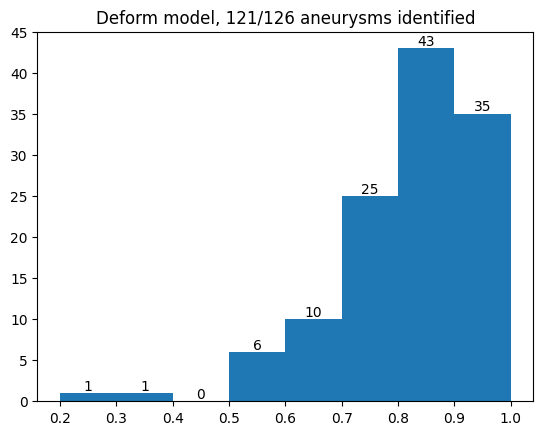

In [14]:
import matplotlib.pyplot as plt

plt.hist(ioa.numpy(), bins=[0.1 * i for i in range(2, 11)])
plt.title("Deform model, 121/126 aneurysms identified")
# set y range to 0-40
plt.ylim(0, 45)
# for each bar in the histogram, paint its height on top of it
for rect in plt.gca().patches:
    plt.gca().text(
        rect.get_x() + rect.get_width() / 2,
        rect.get_height(),
        f"{rect.get_height():.0f}",
        ha="center",
        va="bottom",
    )